In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import datetime
import numpy as np

!pip install tensorflow

!pip install pyupbit

!pip install pykrx

Step 1 탐색: 시간정보가 포함된 데이터 살펴보기
    https://www.investing.com/crypto/bitcoin/historical-data

In [2]:
# 2022년 6월 30일 00:00 (한국시간 기준) 비트코인의 가격 Chapter11.html
# ▶ Data read
df = pd.read_csv('C:\\Users\\hansl\\OneDrive\\바탕 화면\\주가예측\\Bitcoin.csv')
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jun 25, 2022","21,489.9","21,226.9","21,553.4","20,917.5",66.63K,1.24%
1,"Jun 24, 2022","21,226.9","21,100.9","21,488.7","20,743.9",104.56K,0.60%
2,"Jun 23, 2022","21,100.7","19,967.3","21,189.8","19,907.5",110.70K,5.68%
3,"Jun 22, 2022","19,965.8","20,720.2","20,864.3","19,780.2",125.94K,-3.64%
4,"Jun 21, 2022","20,720.4","20,571.6","21,689.3","20,371.7",136.32K,0.72%
5,"Jun 20, 2022","20,572.3","20,576.9","20,996.8","19,658.8",140.60K,-0.02%
6,"Jun 19, 2022","20,577.2","18,983.4","20,763.5","17,983.7",169.39K,8.38%
7,"Jun 18, 2022","18,986.5","20,446.4","20,744.7","17,630.5",267.25K,-7.13%
8,"Jun 17, 2022","20,444.6","20,391.3","21,315.4","20,244.1",136.27K,0.28%
9,"Jun 16, 2022","20,386.6","22,577.9","22,942.1","20,231.1",144.00K,-9.71%


In [3]:
# ▶ Data 형태 확인
print('df', df.shape)

df (731, 7)


In [4]:
# ▶ Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      731 non-null    object
 1   Price     731 non-null    object
 2   Open      731 non-null    object
 3   High      731 non-null    object
 4   Low       731 non-null    object
 5   Vol.      731 non-null    object
 6   Change %  731 non-null    object
dtypes: object(7)
memory usage: 40.1+ KB


In [5]:
# ▶ Null 값 확인
print(df.isnull().sum())

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [6]:
df.drop(['Open','High', 'Low', 'Vol.', 'Change %'], axis=1, inplace=True)

In [7]:
df

,Date,Price
0,"Jun 25, 2022","21,489.9"
1,"Jun 24, 2022","21,226.9"
2,"Jun 23, 2022","21,100.7"
3,"Jun 22, 2022","19,965.8"
4,"Jun 21, 2022","20,720.4"
...,...,...
726,"Jun 29, 2020","9,185.4"
727,"Jun 28, 2020","9,124.0"
728,"Jun 27, 2020","9,008.3"
729,"Jun 26, 2020","9,160.0"


In [8]:
# ▶ 시간 데이터 형변환
import datetime
# df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
# ▶  2년치에 Data 확인
df['Date'].min(), df['Date'].max()

(Timestamp('2020-06-25 00:00:00'), Timestamp('2022-06-25 00:00:00'))

In [10]:
#파이썬에서 datatype : object를 float64로 변환
import numpy as np
df['Price'] = df['Price'].str.replace(',','').astype(np.float64)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    731 non-null    datetime64[ns]
 1   Price   731 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.5 KB


from collections import Counter as cc
cnt = cc(df['Change %'])
cnt.most_common()[:770]

df['Vol.'] = df['Vol.'].str.replace('K','','M','').astype(np.float64)

그리고 이번에는 시계열 정보를 데이터 프레임의 index로 설정한 것이다. to_datetime()을 사용하여 day피처를 시계열 피처로 변환 시켜준다.

In [12]:
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df['Date'].index = df['Date']
df.set_index('Date', inplace=True)
df

,Price
Date,
2022-06-25,21489.9
2022-06-24,21226.9
2022-06-23,21100.7
2022-06-22,19965.8
2022-06-21,20720.4
...,...
2020-06-29,9185.4
2020-06-28,9124.0
2020-06-27,9008.3


In [14]:
df.sort_values(by='Date', ascending= True, inplace=True)

In [15]:
df

,Price
Date,
2020-06-25,9247.5
2020-06-26,9160.0
2020-06-27,9008.3
2020-06-28,9124.0
2020-06-29,9185.4
...,...
2022-06-21,20720.4
2022-06-22,19965.8
2022-06-23,21100.7


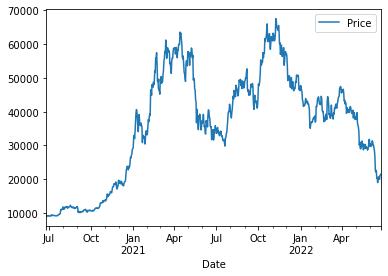

In [16]:
df.plot()
plt.show()

Step 2 예측: 파이썬 라이브러리를 활용한 시세 예측
ARIMA
우선 사용할 시계열 예측 분석은 ARIMA 분석 방법이다. ARIMA기법은 전통적인 시계열 예측 방법으로 크게 두 가지 개념을 포함하고 있다. 첫번째는 AR(Autoregression) 모델로 자기 자신의 과거를 정보로 사용하는 개념이다. 이는 ’현재의 상태는 이전의 상태를 참고해서 계산된다’라는 아이디어를 기본 전제로 한다. 두번째 개념은 MA(Moving Average)모델로 ’이번 항에서의 오차를 이용하여 현재 항의 상태를 추론하자’라는 방법이다. 그리고 이 둘을 합친것을 ARMA 모델이라고 하며, 조금 더 나아간 ARIMA(Autoregressice Integrated Moving Average)모델은 ARMA 모델에 추세 변동의 경향성 까지 반영한 방법이다.
파이썬에서는 statsmodel 모듈로 ARIMA 분석을 수행할 수 있다. 다음 코드는 ARIMA 분석의 실행 과정이다. ARIMA 클래스에 order=(2,1,2)라고 입력되어진 파라미터는 ’AR이 몇번째 과거까지를 바라보는지에 대한 파라미터 (2), 차분(Defference)에 대한 파라미터(1), MA가 몇 번째 과거까지를 바라보는지에 대한 파라미터(2)’를 의미한다.
차분이란 현재 상태의 변수에서 바로 전 상태의 변수를 빼주는 것을 의미하며, 시계열 데이터의 불규칙성을 조금이나마 보정해주는 역할을 한다. 또한 앞서 말한 ARIMA 모델의 경향성을 의미한다.
이제 아래의 실행 결과를 분석해보자. 실행 결과의 표를 살펴보면 상수항을 제외한 모든 계수의 p-value( P>|z| )가 0.05이하로 유의미한 것으로 나타난다. 이것은 AR과 MA모두 2로 설정하는 것이 꽤나 의미 있는 분석 결과를 도출한다는 것을 말한다.

In [17]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [18]:
# (AR = 2, 차분 =1, MA=2) 파라미터로 ARIMA 모델을 학습한다.
model = ARIMA(df.Price.values, order = (2,1,2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [19]:
model_fit = model.fit(trend = 'c', full_output = True, disp = True)

In [20]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  730
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6383.154
Method:                       css-mle   S.D. of innovations           1517.784
Date:                Tue, 28 Jun 2022   AIC                          12778.307
Time:                        00:11:02   BIC                          12805.866
Sample:                             1   HQIC                         12788.940
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7708     54.890      0.306      0.760     -90.812     124.354
ar.L1.D.y      0.8153      0.063     12.846      0.000       0.691       0.940
ar.L2.D.y     -0.9134      0.152     -6.016      0.0

잠깐: ARIMA 분석의 파라미터
위 예제의 분석 결과와는 별개로 order 파라미터 p, d, q는 일반적인 가이드라인이 존재한다. 보통은 p와 q의 합이 2 미만인 경우, 혹은 p와 q의 곱이 0을 포함한 짝수인 경우가 좋은 파라미터의 조합이라고 알려져 있다.

다음으로 ARIMA 모델의 학습 결과를 알아보자. 아래의 실행 결과 중 첫 번째 그래프는 학습한 모델에 학습 데이터셋을 넣었을 때의 시계열 예측 결과이다. plot_predic()함수를 사용해보자.

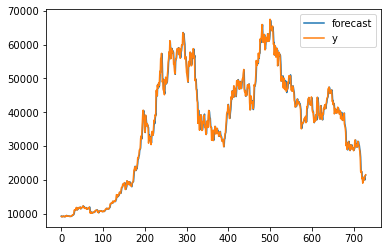

In [21]:
# 학습 데이터에 대한 예측 결과
fig = model_fit.plot_predict()

두번째 그래프는 실제값과 예측값 사이의 오차 변동을 나타내는 그래프이다. 만약 이 그래프의 폭이 일정하다면 좋은 예측 모델을 학습시킨것이라고 생각할 수 있다.

<AxesSubplot:>

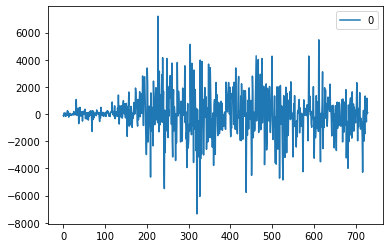

In [22]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

이번에는 ARIMA 모델을 평가해보자. 모델을 평가하기 위해서는 테스트 전용 데이터가 필요한데, 이번에는 5일 동안의 미래를 테스트 데이터로 사용해보자. 불규칙적 시계열 예측의 경우에는 먼 미래를 예측하는 것의 큰 의미가 없기 때문에 ’앞으로 N일동안 어느정도로 상승/하락할 것이다’정도의 대략적인 경향 예측만을 수행하는 것이 일반적이기 때문이다. 모델의 평가 과정은 다음과 같다.

model_fit.forecast(steps = 5)로 향후 5일의 가격을 예측하요 pred_y로 정의 한다.
bitcoin_df.iloc[361:]로 해주어 bitcoin_df의 마지막 5일을 test_y로 정의 한다.
모델의 예측한 상한값, 하한값을 pred_y_upper, pred_y_lower로 정의 한다.
정의한 모든 값을 비교하여 5일동안의 상승 경향 예측이 얼마나 맞는지 평가 해본다.

In [23]:
forecast_data = model_fit.forecast(steps=5) 

test_df = df[731:]
test_df
# 데스트 데이터 셋 불러오기
# test_file_path = "C:\\Users\\hansl\\OneDrive\\바탕 화면\\주가예측\\test.csv"
# test_df = pd.read_csv(test_file_path, names = ['Date','Price'])

,Price
Date,


In [24]:
# 마지막 5일의 예측 데이터 
pred_y = forecast_data[0].tolist()

# 실제 5일의 데이터 
test_y = test_df.Price.values

# 마지막 5일의 예측 데이터 최소값
pred_y_lower = []
# 마지막 5일의 예측 데이터 최대값
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

그리고 다음 코드는 이를 그래프로 시각화 한 것이다. 파란색 그래프는 모델이 예상한 최고 가격, 즉 상한가의 그래프이다. 그리고 빨간색은 모델이 예측한 하한가 그래프이고, 초록색은 실제 5일간의 가격 그래프, 노란색은 모델이 예측한 가격 그래프를 나타낸 것이다.

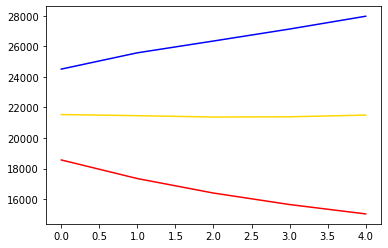

In [25]:
# 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

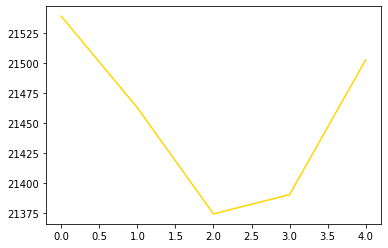

In [26]:
# 상한가, 하한가를 제외한 그래프
plt.plot(pred_y, color = 'gold')
plt.plot(test_y, color = 'green')

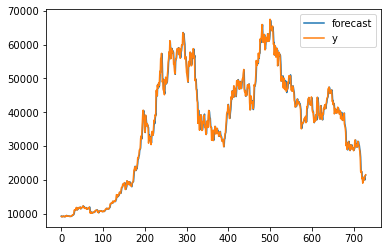

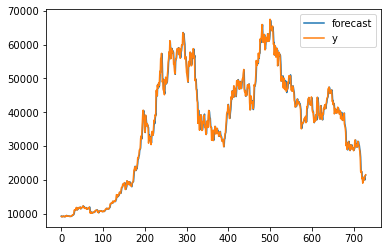

In [27]:
model_fit.plot_predict()

예측값과 실제 값을 그래프로 그려보니 거의 비슷하게 나오고 있습니다

In [28]:
fore = model_fit.forecast(steps=1)
print(fore)

(array([21538.71851173]), array([1517.78369929]), array([[18563.9171248 , 24513.51989865]]))


내일의 코스피 예측값을 보니

6.26일의 주가가 21538.71로 나왔습니다

범위는 18563.91부터 24513.51까지이고요

범위의 상하 범위가 굉장히 크게 나타나서

예측의 범위가 작아 보이지는 않는다

In [31]:
fore = model_fit.forecast(steps=5)
print(fore)
print("6월 30일 비트코인의 가격 : " , 21502.47)

(array([21538.71851173, 21462.66042326, 21374.47583699, 21390.46905721,
       21502.47400574]), array([1517.78369929, 2101.09128265, 2539.72048679, 2931.80481068,
       3302.17907753]), array([[18563.9171248 , 24513.51989865],
       [17344.59718103, 25580.72366548],
       [16396.71515209, 26352.2365219 ],
       [15644.23721859, 27136.70089583],
       [15030.32194327, 27974.62606821]]))
6월 30일 비트코인의 가격 :  21502.47


Facebook Prophet
이번에는 ARIMA보다 조금 더 정확한 트렌드 예측 분석을 제공하는 라이브러리 ’Facebook Prophet’을 사용해보자. Prophet은 Additive 모델이라는 모델링 방법에 기반한 시계열 예측모델로, 시계열 데이터의 트렌드성(연간/월간/일간)을 예측하는 것에 초점이 맞추어져 있다.

잠깐: Additive 모델
Additive 모델은 선형회귀 분석의 단점을 극복하기 위해 개량된 분석 방법의 하나이다. 시계열 분석 역시 회귀 분석의 한 갈래이기 때문에 회귀 분석의 단점을 가지고 있다. 하지만 회귀 분석의 단점을 극복하기 위해 이 모델은 각 피쳐마다 비선형적인 적합을 가능하게 하는 일련의 방법을 적용한다. 이는 다소 어렵기 때문에 자세한 사항은 다음을 참고 한다.

https://peerj.com/preprints/3190/

fbprophet 라이브러리를 사용하기 위해서는 데이터 프레임의 피쳐를 ’ds’와 ’y’로 변경해야 한다. 그리고 Prophet이라는 클래스를 선언한 뒤, fit() 함수로 모델을 학습시켜준다. 모델 생성에 포함되는 파라미터의 의미는 다음과 같다.

sesonality_mode: 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미하는 파라미터
changepoint_prior_scale: 트렌드가 변경되는 문맥을 반영하는 파라미터. 수치가 높을수록 모델은 과적합에 가까워진다.